In [1]:
import numpy as np
import pylab as plt
import pandas as pd
import math
import scipy as sp
from pymc3 import *


In [2]:
#Synthetic Data Generation
#"True" values of hyperparameters
a_inv_tr = 0.8
mu_muC_tr = 7
sig_muC_tr =1.5
sig_C_tr = 0.5
L = 0
sig_1_tr = 0.3
sig_2_tr = 0.2
sig_3_tr = 0
sig_4_tr = 0.3
sig_5_tr = 0.1
r0_tr = 0.3 
sig_e_tr = 1
sig_M_tr = 0.08

#Simulated hierarchical levels
n_vessels = 10
n_comp = 5
n_frame = 5
n_struc = 3
n_plate = 10
n_comp_tot = n_vessels*n_comp
n_frame_tot = n_comp_tot*n_frame
n_struc_tot = n_frame_tot*n_struc
n_plate_tot = n_struc_tot*n_plate
n_total = n_plate_tot

#Time of Inspection
time = [5,8,10,15]

#Generate data
#Note.  Higher level parameters are duplicated using repmat
alpha_1_tr = np.tile(np.random.normal(loc=0,scale=sig_1_tr,size=10),(750,))
alpha_2_tr = np.tile(np.random.normal(loc=0,scale=sig_2_tr,size=50),(150,))
#alpha_3_tr = np.random.normal(loc=0,scale=sig_3_tr,size=250)
alpha_3_tr = np.zeros(shape=(7500,))
alpha_4_tr = np.tile(np.random.normal(loc=0,scale=sig_4_tr,size=750),(10,))
alpha_5_tr = np.random.normal(loc=0,scale=sig_5_tr,size=(n_total,))

psi2 = np.log(1 + (sig_muC_tr/mu_muC_tr)**2)
lam = np.log(mu_muC_tr) - 0.5*psi2
mu_C_tr = np.tile(np.random.lognormal(mean=lam,sigma=np.sqrt(psi2),size=50),(150,))

mu_M_tr = np.tile(np.random.exponential(scale=a_inv_tr,size=750),(10,))

logR_tr = alpha_1_tr + alpha_2_tr + alpha_3_tr + alpha_4_tr + alpha_5_tr + np.log(r0_tr)

psi2 = np.log(1 + np.divide(sig_C_tr,mu_C_tr))
lam = np.log(mu_C_tr) - 0.5*psi2
C_tr = np.random.lognormal(mean=lam,sigma=np.sqrt(psi2))

psi2 = np.log(1 + np.divide(sig_M_tr,mu_M_tr))
lam = np.log(mu_M_tr) - 0.5*psi2
M_tr = np.random.lognormal(mean=lam,sigma=np.sqrt(psi2))

w_hat_tr = np.tile(20,(n_total,))


Z_obs_sim = []
W_tr_sim = []
for ii in range(np.size(time)):
    D_tr = np.zeros(shape=(n_total,))
    #D_tr[C_tr<time[ii]] = np.multiply((np.tile(time[ii],(n_total,))[C_tr<time[ii]] - C_tr[C_tr<time[ii]]),np.exp(logR_tr)[C_tr<time[ii]])
    D_tr[C_tr<time[ii]] = (time[ii] - C_tr[C_tr<time[ii]])*np.exp(logR_tr[C_tr<time[ii]])
    W_tr =  w_hat_tr + M_tr - D_tr
    W_tr_sim = np.append(W_tr_sim, W_tr)
    Z_obs_sim = np.append(Z_obs_sim,np.random.normal(loc=W_tr,scale=sig_e_tr))

time_p = np.tile(np.arange(n_total).reshape(7500,),(4,))

#Indexing (matching data w/ corresponding structure ID)
vessel_i = np.tile(np.arange(n_vessels),(750,))
comp_j = np.tile(np.arange(n_vessels*n_comp),(150,))
frame_k = np.tile(np.arange(n_vessels*n_comp*n_frame),(30,))
struc_m = np.tile(np.arange(n_vessels*n_comp*n_frame*n_struc),(10,))
plate_n = np.arange(n_total).reshape(7500,)

data_index = pd.DataFrame(data= {'Vessel':vessel_i.tolist(),
                     'Compartment':comp_j.tolist(),
                     'Frame':frame_k.tolist(),
                     'Structure':struc_m.tolist(),
                     'Plate':plate_n.tolist()})

In [3]:
with Model() as corrosion_model:
    #Hyperparamter priors
    a_inv = Uniform('a_inv', 0.1, 1.2)
    #a_inv = Lognormal('a_inv',mu=-0.2697, tau=1/(0.3052**2))
    #a_inv = 0.8
    mu_muC = Uniform('mu_muC', 3, 12)
    #mu_muC = 7
    sig_muC = 1.5
    sig_C = 0.5
    L = 0
    sig_1 = HalfCauchy('sig_1', 5)
    #sig_1 = 0.3
    sig_2 = HalfCauchy('sig_2', 5)
    #sig_2 = 0.2
    sig_3 = 0
    sig_4 = HalfCauchy('sig_4', 5)
    #sig_4 = 0.3
    sig_5 = HalfCauchy('sig_5', 5)
    #sig_5 = 0.1
    r0 = Uniform('r0', 0, 1)
    #r0 = Lognormal('r0', mu=-1.5505, tau=1/(0.8326**2))
    #r0 = 0.3
    sig_e = 1.0
    sig_M = 0.08
    w_hat = 20
    
    #Time vector
    t = np.tile(time[0],(n_plate_tot,))
    t = np.append(t,np.tile(time[1],(n_plate_tot,)))
    t = np.append(t,np.tile(time[2],(n_plate_tot,)))
    t = np.append(t,np.tile(time[3],(n_plate_tot,)))
       
   
    #Vessel Level, i
    alpha_1 = Normal('alpha_1', mu=0, tau=1/(sig_1**2), shape=n_vessels)
    alpha_1_all = alpha_1[data_index['Vessel'].tolist(),]
    
    #Compartment Level, j   
    alpha_2 = Normal('alpha_2', mu=0, tau=1/(sig_2**2), shape=n_comp_tot)
    alpha_2_all = alpha_2[data_index['Compartment'].tolist(),]
    
    psi2_muC = np.log(1 + (sig_muC/mu_muC)**2)
    lam_muC = np.log(mu_muC) - 0.5*psi2_muC
    mu_C = Lognormal('mu_C', mu=lam_muC, tau=1/psi2_muC, shape=n_comp_tot)
    mu_C_all = mu_C[data_index['Compartment'].tolist(),]

    #Frame level, k
    if sig_3 == 0:
        alpha_3_all = 0
    else:
        alpha_3 = Normal('alpha_3', mu=0, tau=1/(sig_3**2), shape=n_frame_tot)
        alpha_3_all = alpha_3[data_index['Frame'].tolist(),]
        
    #Struc Elem Level, m
    alpha_4 = Normal('alpha_4', mu=0, tau=1/(sig_4**2), shape=n_struc_tot)
    alpha_4_all = alpha_4[data_index['Structure'].tolist(),]
    
    mu_M = Exponential('mu_M', lam=1/a_inv, shape=n_struc_tot)
    mu_M_all = mu_M[data_index['Structure'].tolist(),]
      
    #Plate Elem Level, n
    alpha_5 = Normal('alpha_5', mu=0, tau=1/(sig_5**2), shape=n_plate_tot)
       
  
    logR = alpha_1_all + alpha_2_all + alpha_3_all + alpha_4_all + alpha_5 + np.log(r0)
    R_all = logR[time_p.tolist(),]
    
    psi2_C = np.log(1 + (sig_C/mu_C_all)**2)
    lam_C = np.log(mu_C_all) - 0.5*psi2_C
    C = Lognormal('C', mu=lam_C, tau=1/psi2_C, shape=n_plate_tot)
    #C = C_tr
    C_all = C[time_p.tolist(),]
    
    psi2_M = np.log(1 + (sig_M/mu_M_all)**2)
    lam_M = np.log(mu_M_all) - 0.5*psi2_M
    M = Lognormal('M', mu=lam_M, tau=1/psi2_M, shape=n_plate_tot)
    #M = M_tr
    M_all = M[time_p.tolist(),]         
   
    diff = (t - C_all).clip(0,100)
    D_t = diff*np.exp(R_all)
    W = w_hat + M_all - D_t

    Z = Normal('Z', mu=W, tau=1/sig_e**2, observed=Z_obs_sim)


In [4]:
with corrosion_model:
    step = Metropolis()
    trace = sample(20000, step=step)

100%|██████████| 20000/20000 [11:52<00:00, 28.06it/s]


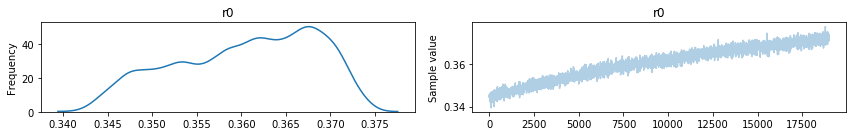

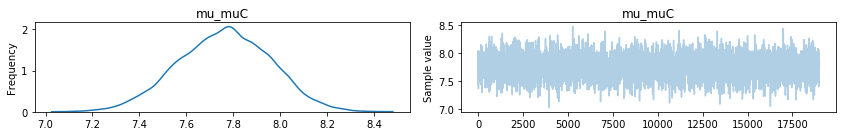

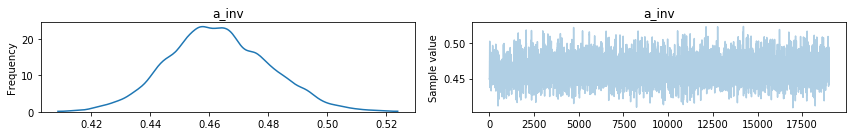

In [5]:
%matplotlib inline
from pymc3 import traceplot

traceplot(trace[1000:], varnames=['r0']);
traceplot(trace[1000:], varnames=['mu_muC']);
traceplot(trace[1000:], varnames=['a_inv']);

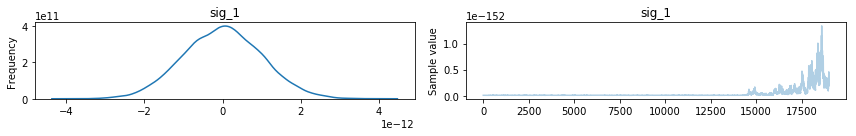

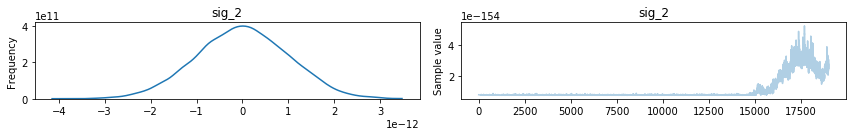

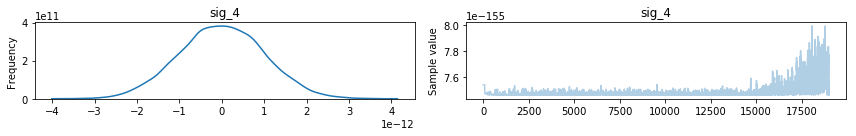

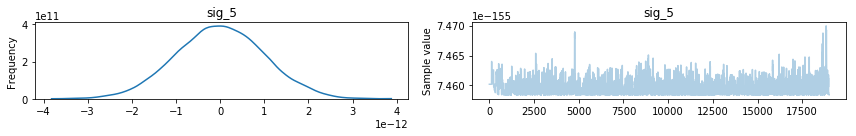

In [6]:
%matplotlib inline
from pymc3 import traceplot

traceplot(trace[1000:], varnames=['sig_1']);
traceplot(trace[1000:], varnames=['sig_2']);
traceplot(trace[1000:], varnames=['sig_4']);
traceplot(trace[1000:], varnames=['sig_5']);